Introdução

---


Com tudo o que você aprendeu, suas consultas SQL estão ficando muito longas, o que pode torná-las difíceis de entender (e depurar).

Você está prestes a aprender como usar AS e WITH para organizar suas consultas e torná-las mais fáceis de ler.

Ao longo do caminho, usaremos a tabela de animais de estimação familiares, mas agora inclui as idades dos animais.

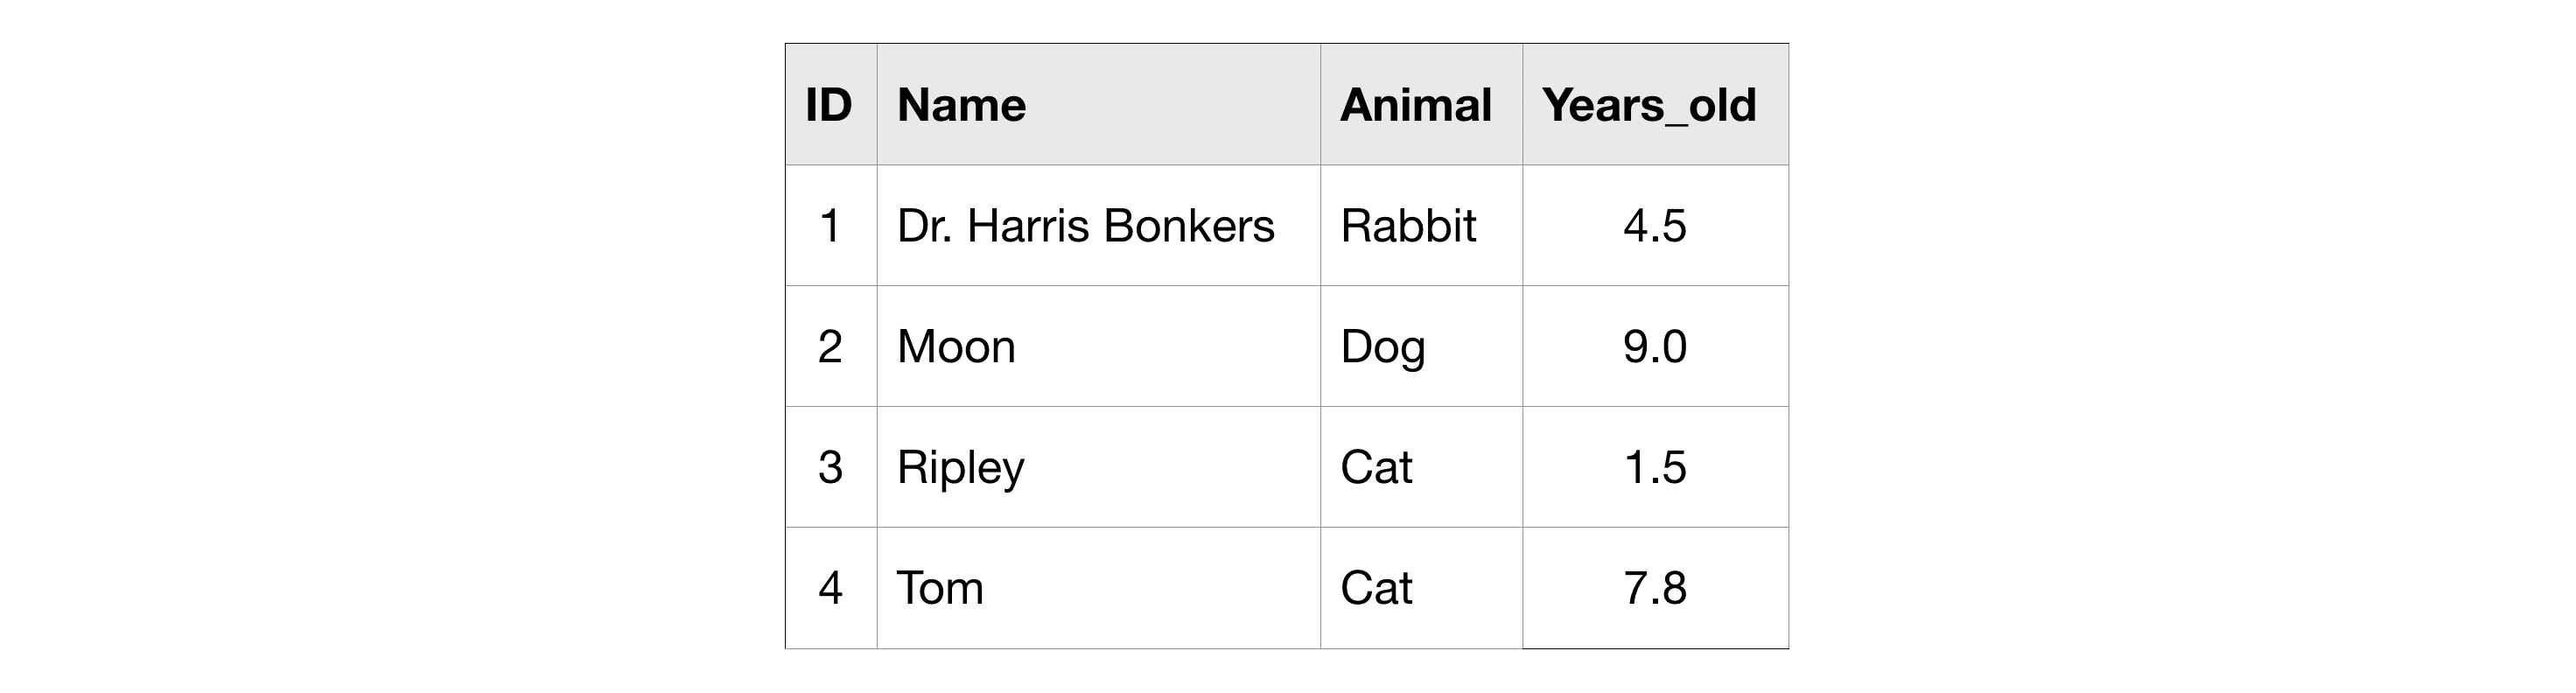

## AS

---


Você aprendeu em um tutorial anterior como usar AS para renomear as colunas geradas por suas consultas, o que também é conhecido como alias. Isso é semelhante a como o Python usa como alias ao fazer importações como import pandas as pd ou import seaborn as sns.

Para usar AS no SQL, insira-o logo após a coluna selecionada. Aqui está um exemplo de uma consulta sem uma cláusula AS:

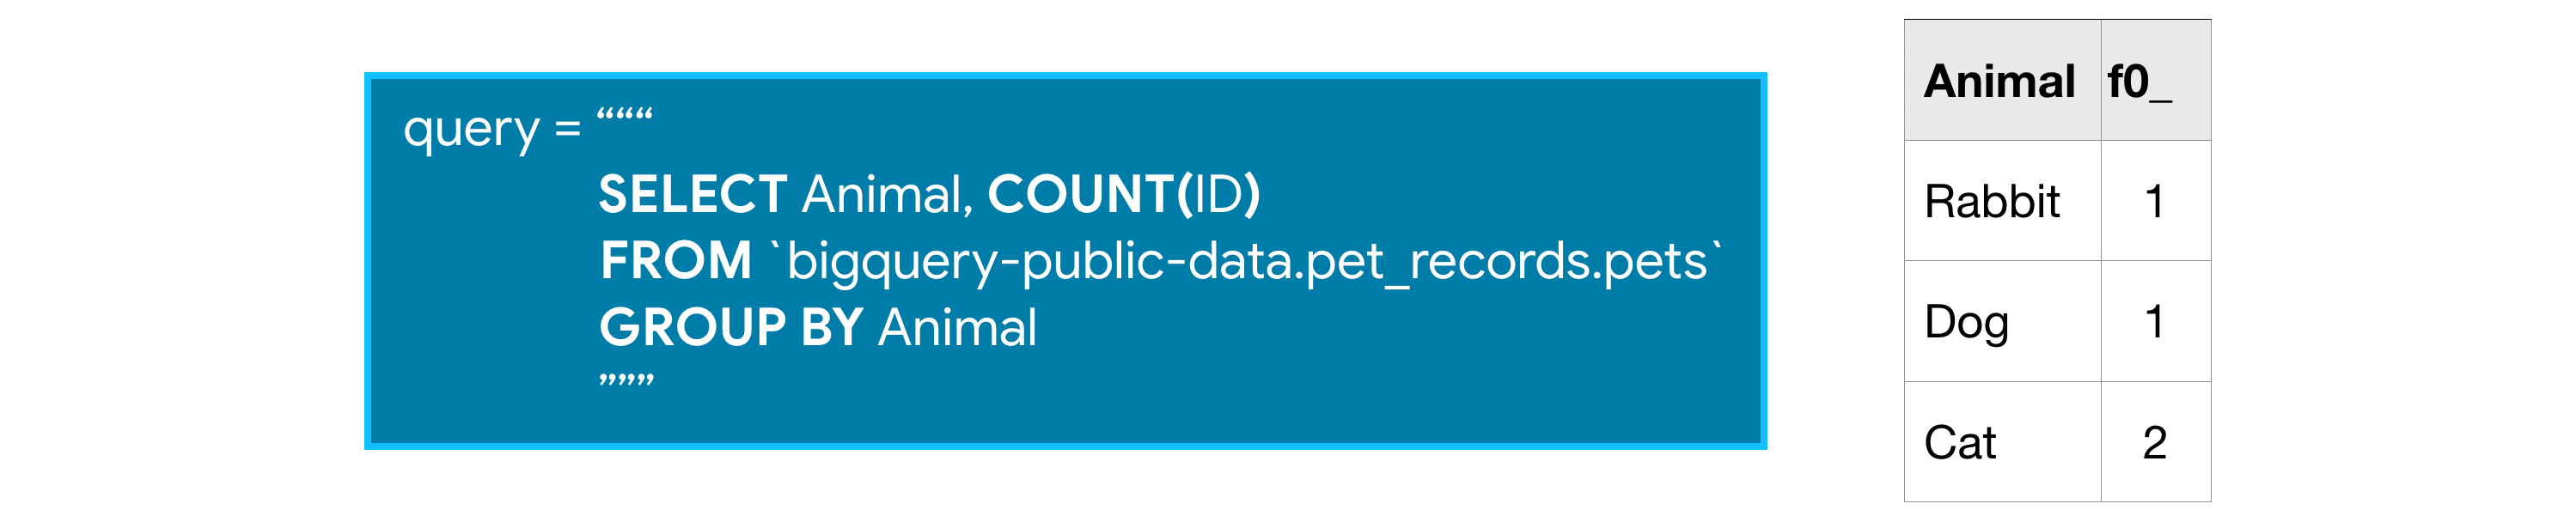

E aqui está um exemplo da mesma consulta, mas com AS

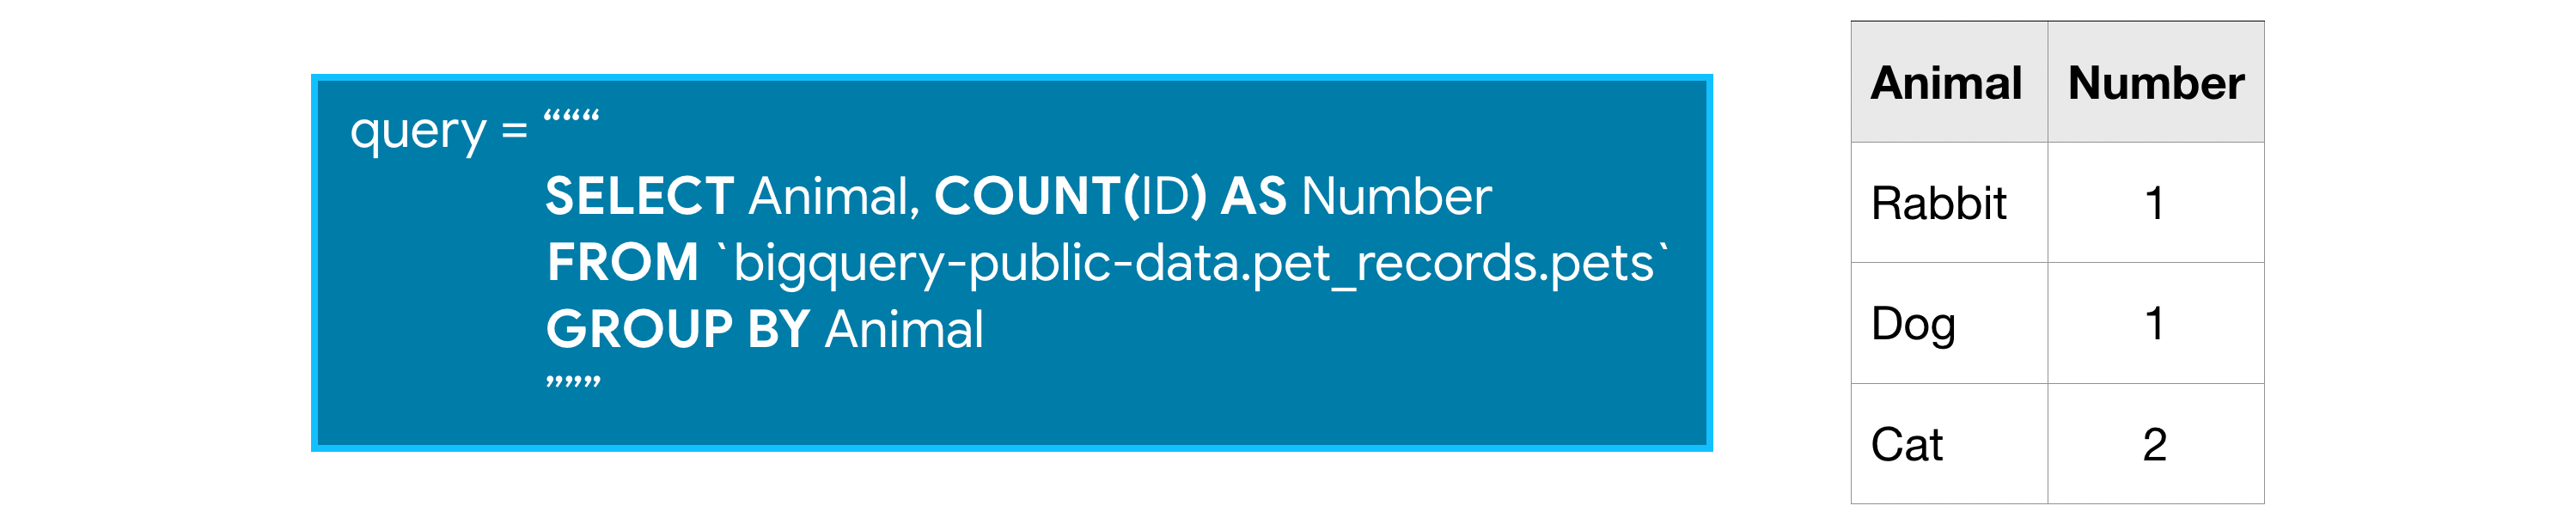

Essas consultas retornam as mesmas informações, mas na segunda consulta a coluna retornada pela função COUNT() será chamada de Number, em vez do nome padrão de f0__



## WITH ... AS

---


Por si só, o AS é uma maneira conveniente de limpar os dados retornados por sua consulta. É ainda mais poderoso quando combinado com WITH no que é chamado de "expressão de tabela comum".

Uma expressão de tabela comum (ou CTE) é uma tabela temporária que você retorna em sua consulta. As CTEs são úteis para dividir suas consultas em partes legíveis e você pode escrever consultas nelas.

Por exemplo, você pode usar a tabela de animais de estimação para fazer perguntas sobre animais mais velhos em particular. Então você pode começar criando um CTE que contém apenas informações sobre animais com mais de cinco anos assim:

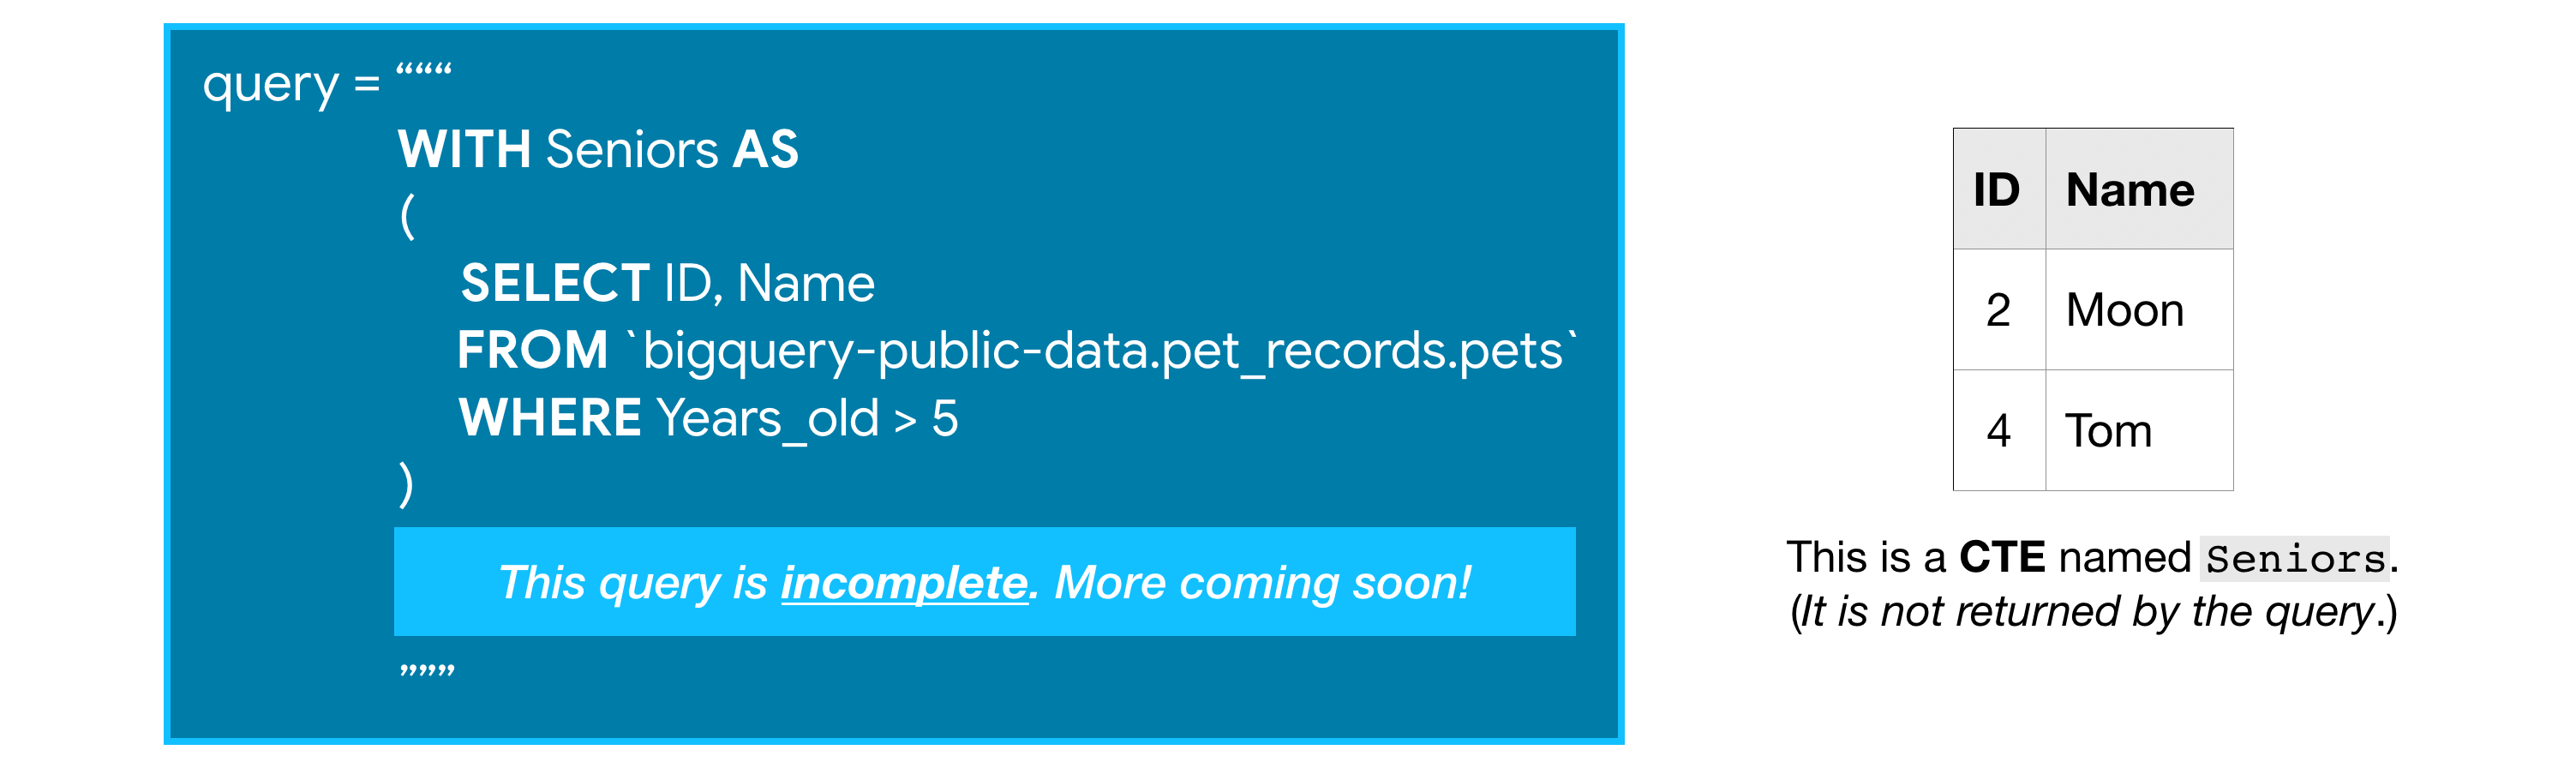

Embora essa consulta incompleta acima não retorne nada, ela cria um CTE ao qual podemos nos referir (como Seniors) enquanto escrevemos o restante da consulta.

Podemos finalizar a consulta extraindo as informações que queremos do CTE. A consulta completa abaixo primeiro cria o CTE e, em seguida, retorna todos os IDs dele.

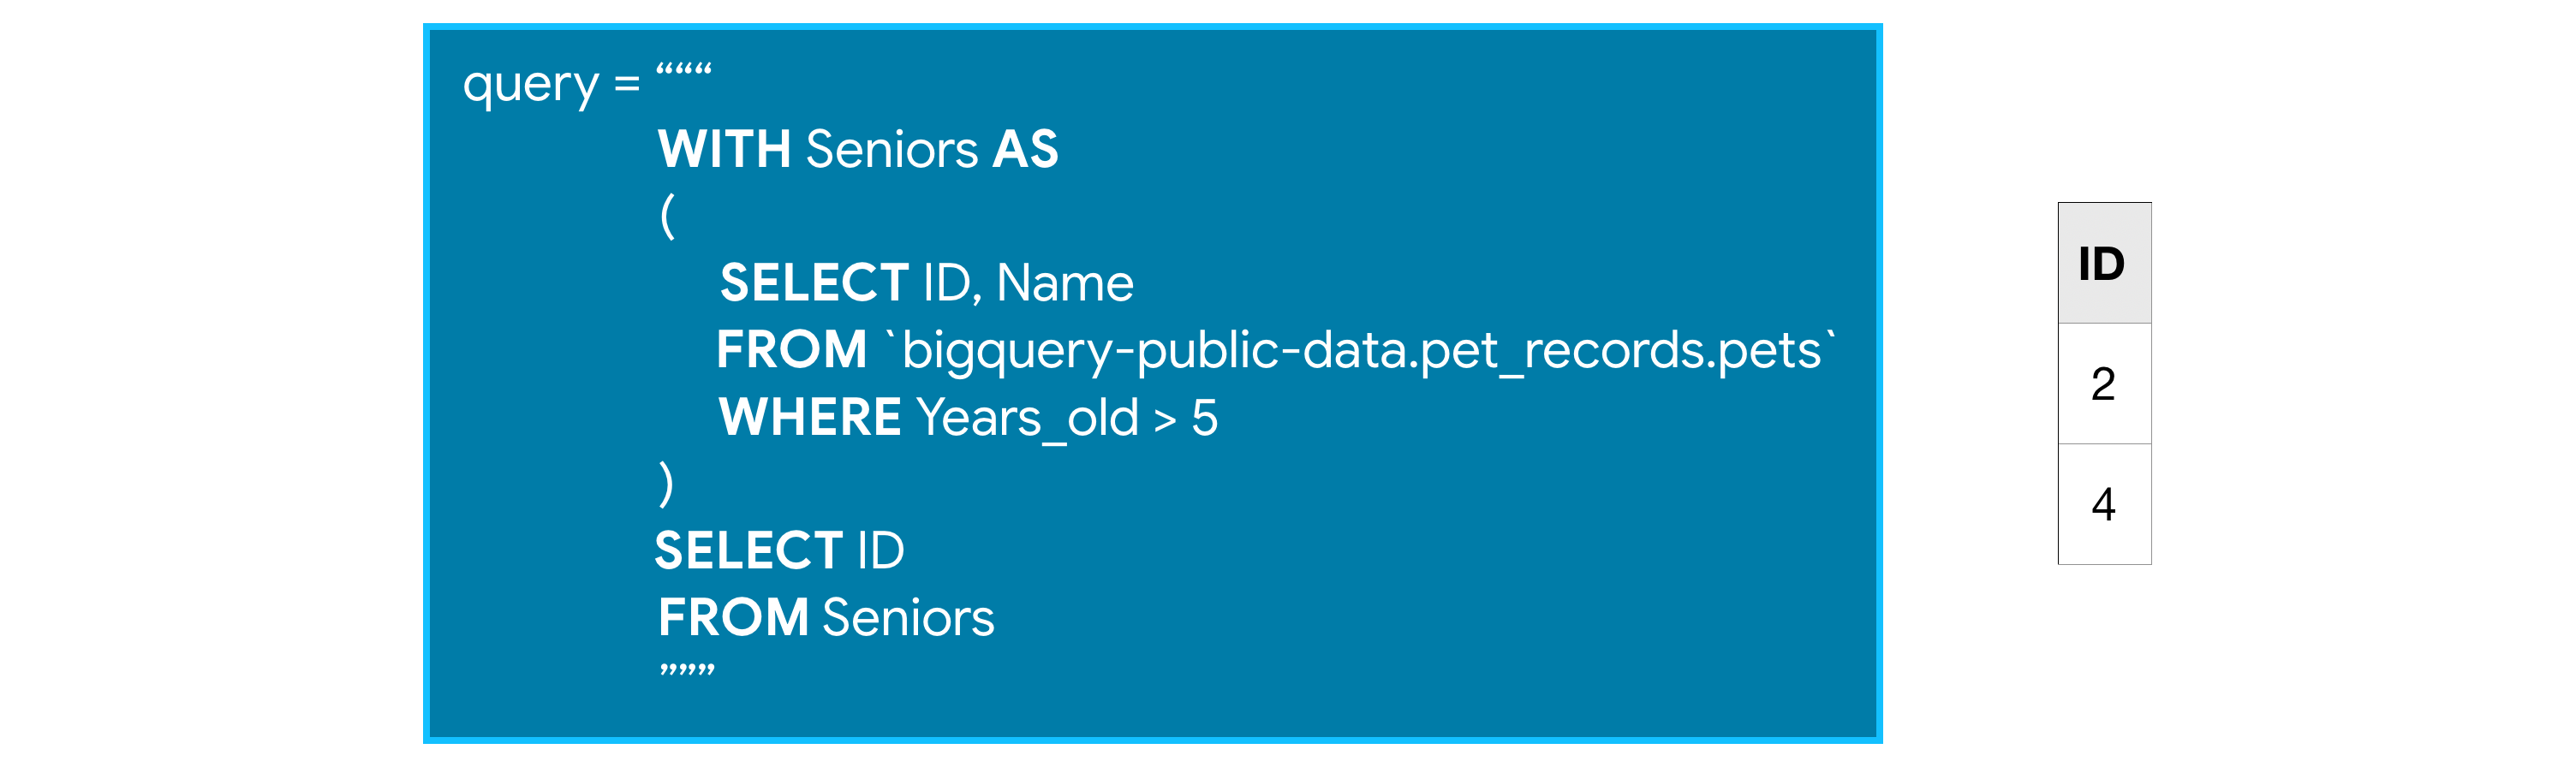

Você poderia fazer isso sem um CTE, mas se esta fosse a primeira parte de uma consulta muito longa, a remoção do CTE tornaria muito mais difícil de seguir.

Além disso, é importante observar que os CTEs só existem dentro da consulta em que você os cria e não é possível referenciá-los em consultas posteriores. Assim, qualquer consulta que usa um CTE é sempre dividida em duas partes: (1) primeiro, criamos o CTE e, em seguida, (2) escrevemos uma consulta que usa o CTE.

## Exemplo: Quantas transações Bitcoin são feitas por mês?

---


Vamos usar um CTE para descobrir quantas transações Bitcoin foram feitas a cada dia durante todo o período de um conjunto de dados de transações bitcoin.

Investigaremos a tabela de transações. Aqui está uma visão das primeiras linhas. (O código correspondente está oculto, mas você pode reexibi-lo clicando no botão "Código" abaixo.)

In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

Como a coluna block_timestamp contém a data de cada transação no formato DATETIME, vamos convertê-las no formato DATE usando o comando DATE().

Fazemos isso usando um CTE e, em seguida, a próxima parte da consulta conta o número de transações para cada data e classifica a tabela para que as datas anteriores apareçam primeiro.

In [ ]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

Como eles são retornados classificados, podemos plotar facilmente os resultados brutos para nos mostrar o número de transações Bitcoin por dia durante todo o período desse conjunto de dados.

In [ ]:
transactions_by_date.set_index('trans_date').plot()

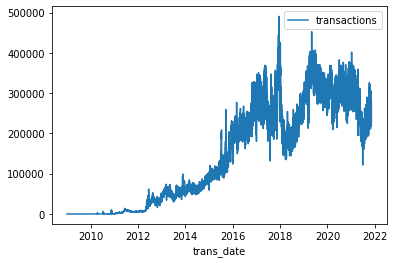

Como você pode ver, expressões de tabela comuns (CTEs) permitem que você mude muito de sua limpeza de dados para SQL. Isso é especialmente bom no caso do BigQuery, porque é muito mais rápido do que fazer o trabalho no Pandas.